In [36]:
# Model Building
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For running this notebook either locally or in colab
import sys

In [2]:
%%capture
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
# For encoding categorical data
from category_encoders import OneHotEncoder

# NYC Rent

**GOAL:** Improve our model for predicting NYC rent prices.

**Objectives**

- Do one-hot encoding of categorical features
- Do univariate feature selection
- Use scikit-learn to fit Ridge Regression models

# I. Wrangle Data

Create **wrangle function** for **reproducibility**.

In [4]:
def wrangle(filepath):
  df = pd.read_csv(
      filepath,
      parse_dates=['created'],
      index_col='created'
  )
  
  # Remove outlier observations
  df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
          (df['price'] <= np.percentile(df['price'], 99.5)) & 
          (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
          (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
          (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
          (df['longitude'] <= np.percentile(df['longitude'], 99.95))]
  # df.drop(columns=['description', 'display_address', 'street_address'], inplace=True)
  drop_cols = [col for col in df.select_dtypes('object') if df[col].nunique() > 10]
  df.drop(columns=drop_cols, inplace=True)
  return df

df = wrangle(DATA_PATH+'apartments/renthop-nyc.csv')
print(df.shape)
print(df.info())
df.head()

(48817, 30)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48817 entries, 2016-06-24 07:54:24 to 2016-04-12 02:48:07
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             48817 non-null  float64
 1   bedrooms              48817 non-null  int64  
 2   latitude              48817 non-null  float64
 3   longitude             48817 non-null  float64
 4   price                 48817 non-null  int64  
 5   interest_level        48817 non-null  object 
 6   elevator              48817 non-null  int64  
 7   cats_allowed          48817 non-null  int64  
 8   hardwood_floors       48817 non-null  int64  
 9   dogs_allowed          48817 non-null  int64  
 10  doorman               48817 non-null  int64  
 11  dishwasher            48817 non-null  int64  
 12  no_fee                48817 non-null  int64  
 13  laundry_in_building   48817 non-null  int64  
 14  fitness_center        4

,bathrooms,bedrooms,latitude,longitude,price,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,...,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,1.5,3,40.7145,-73.9425,3000,medium,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-06-12 12:19:27,1.0,2,40.7947,-73.9667,5465,low,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2016-04-17 03:26:41,1.0,1,40.7388,-74.0018,2850,high,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2016-04-18 02:22:02,1.0,1,40.7539,-73.9677,3275,low,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2016-04-28 01:32:41,1.0,4,40.8241,-73.9493,3350,low,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# II. Split Data

Split **target vector** from **feature matrix**.

In [5]:
target = 'price'
y = df[target]
X = df.drop(columns=target)

Split data into **training** and **test** sets.

(Use data from April & May 2016 to train. Use data from June 2016 to test.)

In [6]:
cutoff = '2016-06-01'
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

# III. Establish Baseline

**Note:** This is a **regression** problem because we're predictiong the continuous value `'price'`.

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = [y_train.mean()] * len(y_train)
print('Baseline MAE: ', mean_absolute_error(y_train, y_pred))

Baseline MAE:  1201.8811133682555


# IV. Build Models

**Question:** How can we represent *categorical* features numerically so that we can use them to train our model?

In [ ]:
encode categorical features

**Model 1:** Regular ol' linear regression

In [ ]:
# before we train our model, we need to encode our categorical features
# for high-dimentional data, you have a few options. first is dimentionality reduction using SelectKBest.

**Model 2:** Ridge regression (regularization)

Note: For our Ridge Model, we need the following steps
1. OneHotEncoder (transformer)
2. Ridge (predictor)

In [37]:
model_r = make_pipeline(
    OneHotEncoder(use_cat_names=True), # as many transformers as you want
    StandardScaler(),
    Ridge(alpha=1.0) # one predictor, last step in the pipeline
)

model_r.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['interest_level'], use_cat_names=True)),
                ('standardscaler', StandardScaler()), ('ridge', Ridge())])

**Model 3:** `SelectKBest`

In [ ]:
model_lr_skb = ...

In [82]:
# # ordinal encoding low -> 1, med -> 2, high -> 3

# # one hot encoding low 0/1, med 0/1, high 0/1

# # step 1: import class
# from sklearn.linear_model import LinearRegression, Ridge
# # from sklearn.preprocessing import OneHotEncoder
# from category_encoders import OneHotEncoder
# from sklearn.feature_selection import SelectKBest

# # step 2: instantiate predictor
# transformer_1 = OneHotEncoder(use_cat_names=True)
# transformer_2 = SelectKBest(k=25) # k is a hyperparameter
# # model = LinearRegression()

# # step 3: fit model on training data
# # NEVER refit your transformer when transforming your test data
# # model.fit(X_train, y_train)
# transformer_1.fit(X_train)
# # step 4: transform the data
# XT_train = transformer_1.transform(X_train)
# XT_test = transformer_1.transform(X_test)

# transformer_2.fit(XT_train, y_train)
# XTT_train = transformer_2.transform(XT_train)
# XTT_test = transformer_2.transform(XT_test)

# model = LinearRegression()
# model.fit(XTT_train, y_train)

# model_r = Ridge()
# model_r.fit(XT_train, y_train) # this is the OHE data w/ no SelectKBest

# print(XTT_train.shape)
# print(type(XTT_train))
# # print(XT_train.shape)
# # print(XT_train.info())
# XT_train.head()

(31844, 25)
<class 'numpy.ndarray'>


# V. Check Metrics

In [16]:
# print('training MAE: ', mean_absolute_error(y_train, model.predict(XTT_train)))
# print('test MAE: ', mean_absolute_error(y_test, model.predict(XTT_test)))

In [38]:
print('Ridge training MAE: ', mean_absolute_error(y_train, model_r.predict(X_train)))
print('Ridge test MAE: ', mean_absolute_error(y_test, model_r.predict(X_test)))

Ridge training MAE:  673.1536834062437
Ridge test MAE:  676.1093724962014


# Communicate results

In [39]:
# step 1: get our coefficients
# model_r.named_steps.keys()
coefficients = model_r.named_steps['ridge'].coef_
coefficients
print(len(coefficients))
len(X_train.columns)

31


29

In [26]:
# step 2: get feature names
feat_names = model_r.named_steps['onehotencoder'].get_feature_names()
# X_train.columns
print(len(feat_names))
feat_names

31


['bathrooms',
 'bedrooms',
 'latitude',
 'longitude',
 'interest_level_high',
 'interest_level_low',
 'interest_level_medium',
 'elevator',
 'cats_allowed',
 'hardwood_floors',
 'dogs_allowed',
 'doorman',
 'dishwasher',
 'no_fee',
 'laundry_in_building',
 'fitness_center',
 'pre-war',
 'laundry_in_unit',
 'roof_deck',
 'outdoor_space',
 'dining_room',
 'high_speed_internet',
 'balcony',
 'swimming_pool',
 'new_construction',
 'terrace',
 'exclusive',
 'loft',
 'garden_patio',
 'wheelchair_access',
 'common_outdoor_space']

Text(0.5, 0, 'Feature Importance [$, scaled]')

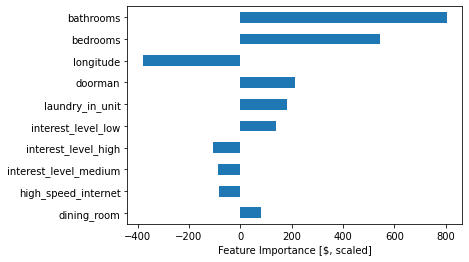

In [41]:
import matplotlib.pyplot as plt
pd.Series(coefficients, index=feat_names).sort_values(key=abs).tail(10).plot(kind='barh')
plt.xlabel('Feature Importance [$, scaled]')